**Predicting Alpha using only train factors dataset.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pandas.io.json import json_normalize
import missingno as msno
import re, string, unicodedata
import nltk
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import string
import time
from time import sleep
from tqdm import tqdm_notebook as tq
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import scipy

# Reading the Data

In [2]:
train_data = pd.read_csv('final_train_data.csv')

In [3]:
test_data = pd.read_csv('final_test_data.csv')

In [4]:
train_data.tail()

,Unnamed: 0,Id,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,Day,Month
27001,27001,27002,RF,-0.946205,1.871952,0.068230,-0.348439,0.439969,0.297584,-0.634398,3,5,10
27002,27002,27003,PG,-0.962175,0.623644,0.468051,0.245506,-0.290927,-0.658470,-1.112317,3,30,7
27003,27003,27004,JCP,1.382757,-1.382645,-0.008343,-0.276788,-0.869303,-1.563029,1.372273,2,16,10
27004,27004,27005,NVDA,1.088894,-1.123395,0.027197,0.914267,-0.680183,-0.375689,0.394336,3,27,7
27005,27005,27006,WBA,-0.637959,0.621395,-0.636104,-0.810184,1.587782,-0.413540,0.101924,2,14,10


In [5]:
test_data.tail()

,Unnamed: 0,Id,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Day,Month
11570,11570,281577,T,-3.442316,0.455191,0.941669,-0.834807,0.278606,-0.233547,-2.755514,3,10
11571,11571,281578,WFC,-1.650993,-0.499109,-0.771762,-2.645119,2.374321,-0.200878,0.353774,21,8
11572,11572,281579,MAT,-1.578543,1.482062,0.672188,0.908843,-0.259848,-0.136924,-2.101467,11,8
11573,11573,281580,RF,-0.027608,0.811717,-0.148925,-0.700263,0.263678,-0.180345,0.435261,22,7
11574,11574,281581,bbby,0.591726,0.435771,-0.009138,-0.912432,-0.410299,0.072242,1.063584,26,7


In [7]:
train_data.dtypes

Unnamed: 0      int64
Id              int64
ticker         object
SF1           float64
SF2           float64
SF3           float64
SF4           float64
SF5           float64
SF6           float64
SF7           float64
alpha           int64
Day             int64
Month           int64
dtype: object

In [8]:
train_data['ticker'] = train_data['ticker'].astype('category')

In [9]:
test_data.dtypes

Unnamed: 0      int64
Id              int64
ticker         object
SF1           float64
SF2           float64
SF3           float64
SF4           float64
SF5           float64
SF6           float64
SF7           float64
Day             int64
Month           int64
dtype: object

In [10]:
test_data['ticker'] = test_data['ticker'].astype('category')

# Seperating X & Y

In [25]:
X = train_data.drop(columns='alpha')
y = train_data['alpha']

# Train - Validation Split

In [26]:
from sklearn.model_selection import train_test_split

In [32]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 26, stratify = y)

In [33]:
print('X Train dimensions: \n\n', x_train.shape, '\n\nX Validation dimensions: \n\n', x_val.shape, 
      '\n\nY Train dimensions:\n\n', y_train.shape, '\n\n Y Validation dimensions: \n\n', y_val.shape)

X Train dimensions: 

 (21604, 12) 

X Validation dimensions: 

 (5402, 12) 

Y Train dimensions:

 (21604,) 

 Y Validation dimensions: 

 (5402,)


# One Hot Encoding Ticker

In [18]:
train_data.dtypes

Unnamed: 0       int64
Id               int64
ticker        category
SF1            float64
SF2            float64
SF3            float64
SF4            float64
SF5            float64
SF6            float64
SF7            float64
alpha            int64
Day              int64
Month            int64
dtype: object

In [34]:
encoded_ticker_train = pd.get_dummies(data = x_train)
encoded_ticker_val = pd.get_dummies(data = x_val)
encoded_ticker_test = pd.get_dummies(data = test_data)

In [35]:
encoded_ticker_train.head()

,Unnamed: 0,Id,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Day,...,ticker_x,ticker_xec,ticker_xlnx,ticker_xom,ticker_xray,ticker_xrt,ticker_yum,ticker_zbh,ticker_zion,ticker_zts
21492,21492,21493,0.021358,0.945042,-0.267387,0.000562,0.506703,0.242560,0.091036,26,...,0,0,0,0,0,0,0,0,0,0
26410,26410,26411,-1.361044,-0.834161,-0.093503,2.147007,1.169477,0.598797,-2.444095,20,...,0,0,0,0,0,0,0,0,0,0
9811,9811,9812,1.838173,-1.239422,-1.469837,0.804025,1.754245,0.936358,1.520345,18,...,0,0,0,0,0,0,0,0,0,0
9392,9392,9393,-2.806140,1.298610,0.490551,1.257951,0.886006,1.087680,-3.330132,21,...,0,0,0,0,0,0,0,0,0,0
24814,24814,24815,-0.334923,-0.554075,0.175425,1.061913,-0.065168,1.884874,-0.974540,24,...,0,0,0,0,0,0,0,0,0,0


**Since the encoded dimensions of ticker for train, validation and test data wont be the same (because some all the tickers won't be present in the val & test), so we reindex the validation and test dataframes with train dataframe columns and fill the values with 0s.**

In [36]:
encoded_ticker_val = encoded_ticker_val.reindex(columns = encoded_ticker_train.columns, fill_value=0)
encoded_ticker_test = encoded_ticker_test.reindex(columns = encoded_ticker_train.columns, fill_value=0)

In [37]:
encoded_ticker_test.head()

,Unnamed: 0,Id,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Day,...,ticker_x,ticker_xec,ticker_xlnx,ticker_xom,ticker_xray,ticker_xrt,ticker_yum,ticker_zbh,ticker_zion,ticker_zts
0,0,270007,-3.062194,1.223466,1.741714,2.279266,-1.323573,-0.274912,-4.504449,21,...,0,0,0,0,0,0,0,0,0,0
1,1,270008,0.816263,-2.184408,0.157975,-0.264743,-0.836282,0.046276,0.826353,5,...,0,0,0,0,0,0,0,0,0,0
2,2,270009,0.401281,0.091604,0.083411,-1.147041,-0.485223,-0.601060,1.012811,1,...,0,0,0,0,0,0,0,0,0,0
3,3,270010,-0.783521,1.192929,0.813831,-0.368166,-1.113656,-0.553581,-0.683803,24,...,0,0,0,0,0,0,0,0,0,0
4,4,270011,0.796507,0.455341,0.679032,0.354336,-1.799055,0.126153,0.297111,27,...,0,0,0,0,0,0,0,0,0,0


# Dropping Columns

In [38]:
final_train = encoded_ticker_train.drop(columns = ['Unnamed: 0', 'Id'])
final_val = encoded_ticker_val.drop(columns = ['Unnamed: 0', 'Id'])
final_test = encoded_ticker_test.drop(columns = ['Unnamed: 0', 'Id'])

In [46]:
final_train.head()

,SF1,SF2,SF3,SF4,SF5,SF6,SF7,Day,Month,ticker_A,...,ticker_x,ticker_xec,ticker_xlnx,ticker_xom,ticker_xray,ticker_xrt,ticker_yum,ticker_zbh,ticker_zion,ticker_zts
21492,0.021358,0.945042,-0.267387,0.000562,0.506703,0.242560,0.091036,26,7,0,...,0,0,0,0,0,0,0,0,0,0
26410,-1.361044,-0.834161,-0.093503,2.147007,1.169477,0.598797,-2.444095,20,8,0,...,0,0,0,0,0,0,0,0,0,0
9811,1.838173,-1.239422,-1.469837,0.804025,1.754245,0.936358,1.520345,18,7,0,...,0,0,0,0,0,0,0,0,0,0
9392,-2.806140,1.298610,0.490551,1.257951,0.886006,1.087680,-3.330132,21,8,0,...,0,0,0,0,0,0,0,0,0,0
24814,-0.334923,-0.554075,0.175425,1.061913,-0.065168,1.884874,-0.974540,24,7,0,...,0,0,0,0,0,0,0,0,0,0


# Model Building

## Load error metrics

In [39]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,f1_score,precision_score
from sklearn.metrics import roc_curve,log_loss,auc

## Decision Tree

### Train

In [49]:
from sklearn import tree
DT_classifier = tree.DecisionTreeClassifier(random_state=26, criterion = 'entropy')


In [50]:
DT_classifier.fit(final_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=26,
            splitter='best')

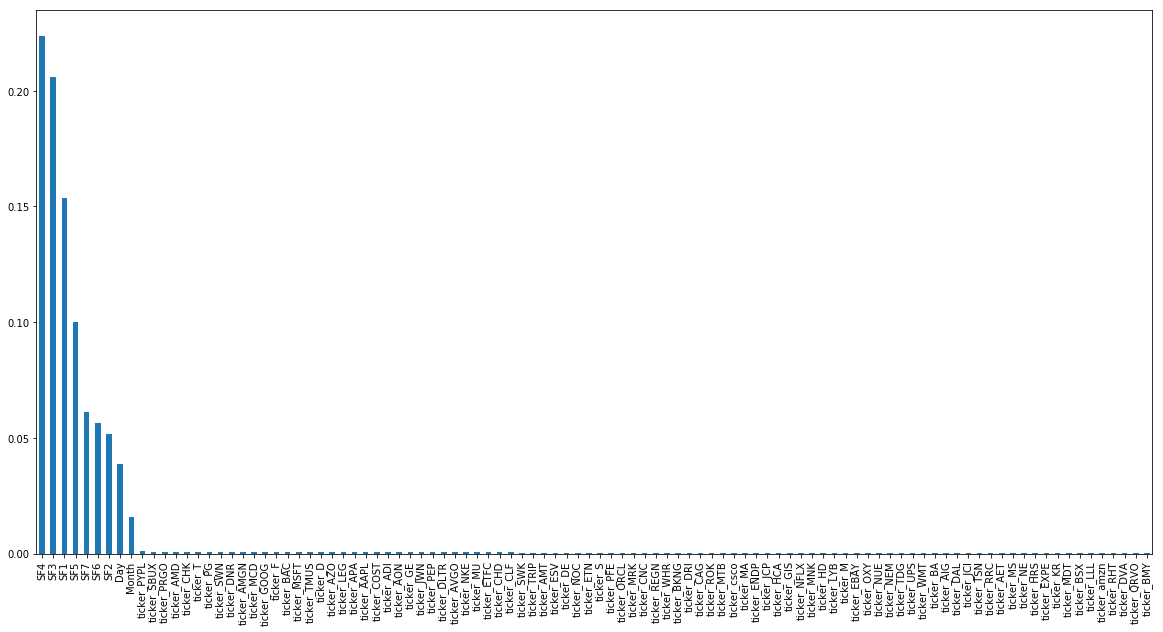

In [52]:
imp_feature = pd.Series(DT_classifier.feature_importances_, index = final_train.columns)
imp_ordered = imp_feature.nlargest(100)
plt.rcParams['figure.figsize'] = (20,10)
imp_ordered.plot(kind = 'bar')

In [53]:
print('\n\n6 Most important feautures: \n\n', imp_ordered.head(2))
print('=========================================')
print('\n\n6 Least important features: \n\n',imp_ordered.tail(2))



6 Most important feautures: 

 SF4    0.223732
SF3    0.205975
dtype: float64


6 Least important features: 

 ticker_QRVO    0.000320
ticker_BMY     0.000317
dtype: float64


In [56]:
y_DT_pred = DT_classifier.predict(final_val)
y_DT_train = DT_classifier.predict(final_train)

In [58]:
print("=========================== \n\n TRAIN DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_train, y_DT_train))
print("\n\n========================== \n\n Accuracy Score\n\n",accuracy_score(y_train, y_DT_train))
print("\n\n========================== \n\n Classification Report\n\n",classification_report(y_train, y_DT_train))

print("=========================== \n\n VALIDATION DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_val, y_DT_pred))
print("\n\n========================== \n\n Accuracy Score\n\n", accuracy_score(y_val, y_DT_pred))
print("\n\n========================== \n\n Classification Report\n\n", classification_report(y_val, y_DT_pred))


 TRAIN DATA METRICS



 Confusion Matrix

 [[4373    0    0    0]
 [   0 8729    0    0]
 [   0    0 4429    0]
 [   0    0    0 4073]]



 Accuracy Score

 1.0



 Classification Report

               precision    recall  f1-score   support

           1       1.00      1.00      1.00      4373
           2       1.00      1.00      1.00      8729
           3       1.00      1.00      1.00      4429
           4       1.00      1.00      1.00      4073

   micro avg       1.00      1.00      1.00     21604
   macro avg       1.00      1.00      1.00     21604
weighted avg       1.00      1.00      1.00     21604


 VALIDATION DATA METRICS



 Confusion Matrix

 [[ 547  148  254  145]
 [ 120 1803  142  118]
 [ 279  150  506  172]
 [ 163  150  173  532]]



 Accuracy Score

 0.6271751203258052



 Classification Report

               precision    recall  f1-score   support

           1       0.49      0.50      0.50      1094
           2       0.80      0.83      0.81      2183
  

### Test

In [60]:
y_DT_test = DT_classifier.predict(final_test)

In [61]:
DT_pred_file = {'id': encoded_ticker_test['Id'], 'alpha': y_DT_test}

DT_pred_file = pd.DataFrame(DT_pred_file)

DT_pred_file.to_csv('Decision_Tree_Dictionary_Prediction.csv', index = False)

## Random Forest

### Train and Validation

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [63]:
RF_classifier = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=2)

param_grid = {'n_estimators' : [5,7,9,11,13,15,17,19],
             'max_depth' : [2,3,4,5,6,7,8,9,10,11,12],
              "min_samples_leaf" : [5, 10, 15, 20],
              "class_weight" : ['balanced','balanced_subsample']}

In [64]:
rfc_cv = RandomizedSearchCV(estimator=RF_classifier, param_distributions=param_grid, n_iter=10,cv=4)

In [65]:
rfc_cv.fit(final_train, y_train)

RandomizedSearchCV(cv=4, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=2, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': [5, 7, 9, 11, 13, 15, 17, 19], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'min_samples_leaf': [5, 10, 15, 20], 'class_weight': ['balanced', 'balanced_subsample']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [66]:
rfc_cv.best_params_

{'n_estimators': 19,
 'min_samples_leaf': 5,
 'max_depth': 8,
 'class_weight': 'balanced'}

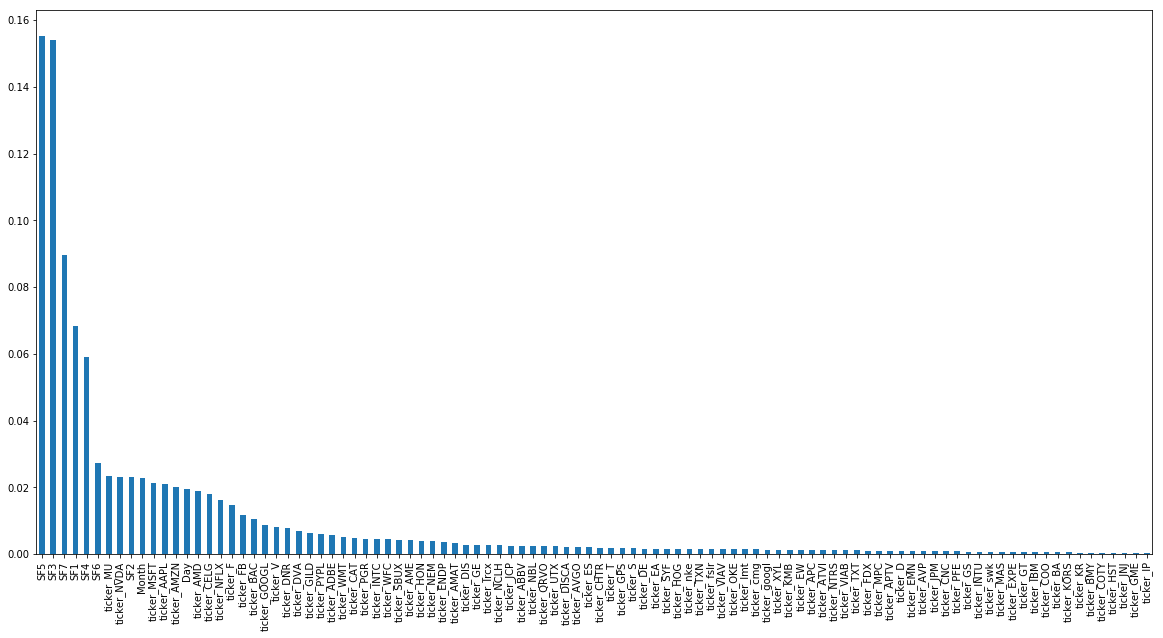

In [67]:
feat_importances = pd.Series(rfc_cv.best_estimator_.feature_importances_, index = final_train.columns)
feat_importances_ordered = feat_importances.nlargest(100)
feat_importances_ordered.plot(kind='bar')

In [68]:
rf_clf = RandomForestClassifier(n_estimators = 19, min_samples_leaf = 5, max_depth = 8, class_weight = 'balanced', criterion = 'entropy')

In [69]:
rf_clf.fit(final_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=8, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=19, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [70]:
y_RF_pred = rf_clf.predict(final_val)
y_RF_train = rf_clf.predict(final_train)

In [71]:
print("=========================== \n\n TRAIN DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_train, y_RF_train))
print("\n\n========================== \n\n Accuracy Score\n\n",accuracy_score(y_train, y_RF_train))
print("\n\n========================== \n\n Classification Report\n\n",classification_report(y_train, y_RF_train))

print("=========================== \n\n VALIDATION DATA METRICS\n\n") 
print("=========================== \n\n Confusion Matrix\n\n", confusion_matrix(y_val, y_RF_pred))
print("\n\n========================== \n\n Accuracy Score\n\n", accuracy_score(y_val, y_RF_pred))
print("\n\n========================== \n\n Classification Report\n\n", classification_report(y_val, y_RF_pred))


 TRAIN DATA METRICS



 Confusion Matrix

 [[1681 1938  622  132]
 [ 685 7212  651  181]
 [ 704 1551 1998  176]
 [ 521 2342  899  311]]



 Accuracy Score

 0.5185150897981855



 Classification Report

               precision    recall  f1-score   support

           1       0.47      0.38      0.42      4373
           2       0.55      0.83      0.66      8729
           3       0.48      0.45      0.46      4429
           4       0.39      0.08      0.13      4073

   micro avg       0.52      0.52      0.52     21604
   macro avg       0.47      0.43      0.42     21604
weighted avg       0.49      0.52      0.47     21604


 VALIDATION DATA METRICS



 Confusion Matrix

 [[ 380  505  169   40]
 [ 166 1804  162   51]
 [ 200  396  467   44]
 [ 135  596  228   59]]



 Accuracy Score

 0.501666049611255



 Classification Report

               precision    recall  f1-score   support

           1       0.43      0.35      0.38      1094
           2       0.55      0.83      0.6

### Test

In [72]:
y_RF_test = rf_clf.predict(final_test)

In [73]:
RF_pred_file = {'id': encoded_ticker_test['Id'], 'alpha': y_RF_test}

RF_pred_file = pd.DataFrame(RF_pred_file)

RF_pred_file.to_csv('Random_Forest_Dictionary_Prediction.csv', index = False)